In [1]:
# MO444-A 2s/2017 - Second assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

from __future__ import print_function
import glob
import random
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
from skimage.io import imread
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Some definitions
classes = np.asarray(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
int_classes = preprocessing.LabelEncoder().fit_transform(classes) # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
onehot_classes = onehot_encoder.fit_transform(int_classes.reshape(len(int_classes), 1))

def load_image_dataset(name, sample=1., as_gray=False):
    """Loads an image dataset
    name: directory in which dataset is defined
    sample: fraction of the dataset to be loaded [0, 1]
    as_gray: read images as grayscale to have a 32x32 matrix, instead of a 32x32x3 matrix in case of RGB.
    """
    random.seed(1)
    X, Y = [], []
    with open('cifar-10/%s/labels' % name) as labels:
        i = 0
        for path in sorted(glob.glob('cifar-10/%s/*.png' % name)):
            y = int(labels.next())
            if random.random() > sample:
                continue
            Y.append(y)
            X.append(imread(path, as_grey=as_gray))
    X, Y = np.array(X), np.array(Y)
    n_dim = reduce(lambda x, y: x * y, X.shape[1:])
    return X.reshape(-1, n_dim), Y

def display_image(x):
    """Prints a colored or grayscale 32x32 image"""
    colors = x.shape[0] / 32 / 32
    cmap = 'gray' if colors == 1 else 'jet'
    new_shape = (32, 32) if colors == 1 else (32, 32, colors)
    plt.imshow(x.reshape(new_shape), cmap=cmap)
    plt.show()


In [2]:
# Load train dataset
data_X, data_Y = load_image_dataset('train', as_gray=True, sample=0.1)
print("Loaded %d samples" % len(data_X))

Loaded 5053 samples


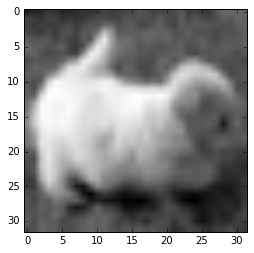

Label: dog


In [3]:
# Take a look at a sample and its class
display_image(data_X[207])

print('Label: %s' % classes[int(data_Y[207])])

In [4]:
# Implementing K-Fold to help avoiding overfitting
from sklearn.model_selection import KFold
from datetime import datetime

random_state = np.random.RandomState(1)

# prepare for 5-fold execution
k5_fold = KFold(n_splits=5, shuffle=True, random_state=random_state)

def run_kfold(method, data_Y, data_X, scale=False):
    train_precision, train_recall, train_f1 = [], [], []
    validation_precision, validation_recall, validation_f1 = [], [], []
    start_time = datetime.now()
    k = 0
    print('k', end=' ')
    model = None

    for train_index, validation_index in k5_fold.split(data_X):
        k += 1
        print(k, end=' ')
        
        train_data_X, train_data_Y = data_X[train_index], data_Y[train_index]
        validation_data_X, validation_data_Y = data_X[validation_index], data_Y[validation_index]
        
        if scale:
            model_scaler = preprocessing.StandardScaler()
            train_data_X = model_scaler.fit_transform(train_data_X)
            validation_data_X = model_scaler.transform(validation_data_X)

        # Train the model(s) using the training data
        model = method(train_data_X, train_data_Y)
        
        # Predict training data
        predicted_train_data_Y = model.predict(train_data_X)
        train_precision.append(precision_score(train_data_Y, predicted_train_data_Y, average='weighted'))
        train_recall.append(recall_score(train_data_Y, predicted_train_data_Y, average='weighted'))
        train_f1.append(f1_score(train_data_Y, predicted_train_data_Y, average='weighted'))
        
        # Predict validation data
        predicted_validation_data_Y = model.predict(validation_data_X)
        validation_precision.append(precision_score(validation_data_Y, predicted_validation_data_Y, average='weighted'))
        validation_recall.append(recall_score(validation_data_Y, predicted_validation_data_Y, average='weighted'))
        validation_f1.append(f1_score(validation_data_Y, predicted_validation_data_Y, average='weighted'))
    
    print('time elapsed: {}\n'.format(datetime.now() - start_time))
    print('           Precision  sd      Recall sd     F1 Score sd')
    print('Training:      %5.2f  ±%5.2f   %5.2f ±%5.2f    %5.2f ±%5.2f' % (
            np.mean(train_precision), np.std(train_precision), np.mean(train_recall), np.std(train_recall), np.mean(train_f1), np.std(train_f1)))
    print('Validation:    %5.2f  ±%5.2f   %5.2f ±%5.2f    %5.2f ±%5.2f' % (
            np.mean(validation_precision), np.std(validation_precision), np.mean(validation_recall), np.std(validation_recall), np.mean(validation_f1), np.std(validation_f1)))
    try:
        model.close()
    except AttributeError:
        print(' ') # Nevermind...
    
    return model

In [5]:
# Create a baseline One-vs-All logistic regression model
ova_lr_model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=100)
run_kfold(lambda X, Y: ova_lr_model.fit(X, Y), data_Y, data_X, scale=True)

k 1 2 3 4 5 time elapsed: 0:00:56.017231

           Precision  sd      Recall sd     F1 Score sd
Training:       0.68  ± 0.00    0.68 ± 0.00     0.68 ± 0.00
Validation:     0.19  ± 0.01    0.19 ± 0.01     0.19 ± 0.01
 


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [6]:
# Create a Multinomial (Softmax) logistic regression model
mn_lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)
run_kfold(lambda X, Y: mn_lr_model.fit(X, Y), data_Y, data_X, scale=True)

k 1 2 3 4 5 time elapsed: 0:00:40.743250

           Precision  sd      Recall sd     F1 Score sd
Training:       0.63  ± 0.01    0.63 ± 0.01     0.63 ± 0.01
Validation:     0.20  ± 0.01    0.20 ± 0.01     0.20 ± 0.01
 


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
# Neural Networks
class NeuralNetwork(object):
    
    def __init__(self, input_size, output_size, learning_rate=0.5, epochs=10):
        tf.reset_default_graph() # To make sure everything is brand new.
        
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        # input data placeholders
        self.x = tf.placeholder(tf.float32, [None, input_size], name='input')
        # output data placeholder
        self.y = tf.placeholder(tf.float32, [None, output_size], name='output')

        # now declare the weights connecting the input to the hidden layer
        W1 = tf.Variable(tf.random_normal([input_size, 300], stddev=0.03), name='W1')
        b1 = tf.Variable(tf.random_normal([300]), name='b1')

        # and the weights connecting the hidden layer to the output layer
        W2 = tf.Variable(tf.random_normal([300, output_size], stddev=0.03), name='W2')
        b2 = tf.Variable(tf.random_normal([output_size]), name='b2')
        
        # hidden layer's output
        Z1 = tf.add(tf.matmul(self.x, W1), b1)
        a1 = self.activation(Z1)
        
        # output with softmax
        Z2 = tf.add(tf.matmul(a1, W2), b2)
        a2 = self.activation(Z2)
        self.y_pred = tf.nn.softmax(a2)
        
        # Cost function
        y_pred_clipped = tf.clip_by_value(self.y_pred, 1e-10, 0.9999999) # To avoid log(0), returning NaN
        self.cost = -tf.reduce_mean(tf.reduce_sum(self.y * tf.log(y_pred_clipped) + (1 - self.y) * tf.log(1 - y_pred_clipped), axis=1))
        
        # Optimizer
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)
        
        # Optimize directly
        self.optimization = optimizer.minimize(self.cost)
        
        # Now, to perform gradient checking
        self.get_gradients = optimizer.compute_gradients(self.cost)
        
        # variables initializer
        self.init_op = tf.global_variables_initializer()
        
        # define a tensorflow session
        self.session = tf.Session()
        self.session.run(self.init_op)

    def activation(self, x):
        return tf.div(tf.constant(1.0), tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))

    def fit(self, X, Y):
        # Apply One Hot Encoding
        Y = onehot_encoder.transform(Y.reshape(len(Y), 1))
        
        costs = []
        # Training
        for epoch in range(self.epochs):
            _, c = self.session.run([self.optimization, self.cost], feed_dict={self.x: X, self.y: Y})
            # print("Epoch:", (epoch + 1), "cost: ", c)
            costs.append(c)
            if epoch == 5:
                # get the gradients and variables to numerically check the gradients
                grads_vars = self.session.run(self.get_gradients, feed_dict={self.x: X, self.y: Y})
                # TODO: check them!

        self.print_costs(costs)
        return self
    
    def print_costs(self, costs):
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('epoch')
        plt.show()

    def predict(self, X):
        # Forward propagation
        prediction = self.session.run(self.y_pred, feed_dict={self.x: X})
        return np.argmax(prediction, 1)
    
    def close(self):
        self.session.close()


k 1 [[ 0.05597578 -0.02417059 -0.00897041 ...,  0.01353923 -0.0343132
   0.05360216]
 [-0.03763046 -0.01826554  0.00110716 ...,  0.00471634 -0.0009763
   0.0113884 ]
 [-0.02190954 -0.0229381   0.0123748  ..., -0.02099616  0.01103909
  -0.06446833]
 ..., 
 [ 0.01217431  0.04035522 -0.00838134 ...,  0.04707151 -0.00998321
   0.05080429]
 [ 0.0123769   0.03086969  0.01031937 ...,  0.0157352  -0.02526255
  -0.02438953]
 [ 0.03031356 -0.02705158 -0.01566768 ..., -0.05920708 -0.03088046
   0.01070544]]


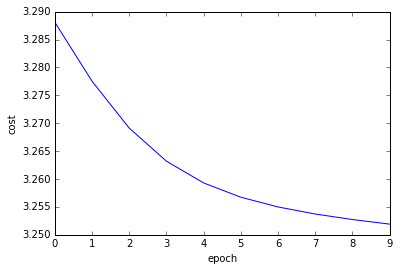

2 [[ 0.05619444 -0.02394525 -0.00890168 ...,  0.01370043 -0.03442524
   0.05344997]
 [-0.03741471 -0.01803925  0.00118126 ...,  0.00487481 -0.00108707
   0.01122086]
 [-0.02169433 -0.02270675  0.01245169 ..., -0.0208374   0.01092527
  -0.06463718]
 ..., 
 [ 0.01225889  0.04038286 -0.00818987 ...,  0.0470551  -0.00993382
   0.05087682]
 [ 0.01247023  0.03090482  0.01051403 ...,  0.01571647 -0.02521891
  -0.02431512]
 [ 0.030413   -0.02701038 -0.01546693 ..., -0.05922682 -0.03084472
   0.01078354]]


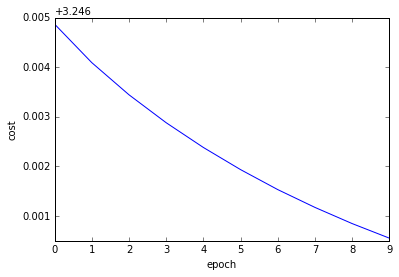

3 [[ 0.05634453 -0.02378137 -0.00892274 ...,  0.01387504 -0.03454465
   0.05330068]
 [-0.03726682 -0.01787546  0.00116533 ...,  0.00504843 -0.00120446
   0.01105738]
 [-0.0215484  -0.02253748  0.01243559 ..., -0.0206644   0.01080521
  -0.06480344]
 ..., 
 [ 0.01226457  0.04034638 -0.00809027 ...,  0.04700842 -0.00986233
   0.0509663 ]
 [ 0.01248674  0.03087464  0.01061345 ...,  0.01567121 -0.02515305
  -0.02422849]
 [ 0.03043792 -0.02703029 -0.01535946 ..., -0.05926606 -0.0307883
   0.01087049]]


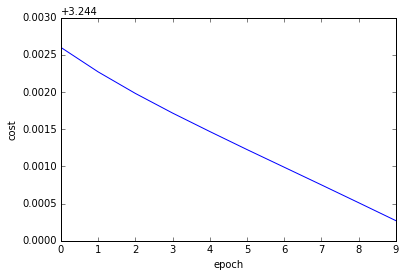

4 [[ 0.05647273 -0.02362307 -0.00897137 ...,  0.014041   -0.03469788
   0.05317051]
 [-0.03713754 -0.01771343  0.00112531 ...,  0.0052167  -0.00135781
   0.01091513]
 [-0.02142104 -0.02237055  0.01239541 ..., -0.02049683  0.01064804
  -0.06494781]
 ..., 
 [ 0.01225805  0.04030314 -0.00800904 ...,  0.04694701 -0.00979389
   0.05108925]
 [ 0.01249467  0.03084077  0.0106977  ...,  0.01561577 -0.02509233
  -0.02411059]
 [ 0.03045914 -0.02705162 -0.01526599 ..., -0.05931146 -0.03073737
   0.01098369]]


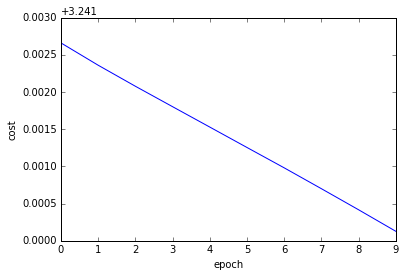

5 [[ 0.0565715  -0.02346259 -0.00902421 ...,  0.01421327 -0.0348761
   0.05300599]
 [-0.03703937 -0.0175496   0.0010786  ...,  0.00538594 -0.00153758
   0.01074457]
 [-0.02132469 -0.0222018   0.0123479  ..., -0.02032967  0.01046145
  -0.06511471]
 ..., 
 [ 0.01221794  0.04025164 -0.00791559 ...,  0.04687342 -0.00971765
   0.05120458]
 [ 0.01247188  0.03079963  0.01079574 ...,  0.01554898 -0.02502086
  -0.02400089]
 [ 0.0304479  -0.02707947 -0.01515571 ..., -0.05936746 -0.03067556
   0.01108846]]


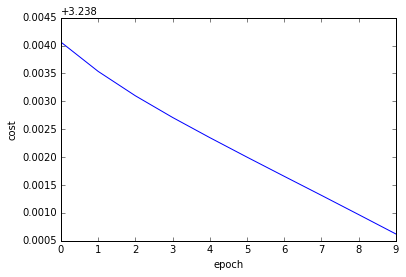

time elapsed: 0:00:15.468084

           Precision  sd      Recall sd     F1 Score sd
Training:       0.04  ± 0.04    0.12 ± 0.02     0.04 ± 0.03
Validation:     0.06  ± 0.07    0.11 ± 0.02     0.04 ± 0.03


In [29]:
# Neural Network with a single hidden layer
nn_single_hl_model = NeuralNetwork(input_size=len(data_X[0]), output_size=len(classes))
run_kfold(lambda X, Y: nn_single_hl_model.fit(X, Y), data_Y, data_X)